### Import Relevant Modules

In [1]:
import pandas as pd
%matplotlib inline

import math
import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

import seaborn as sns
sns.set(color_codes=True)

#from datetime import datetime
from datetime import timedelta
import datetime
import time
import os

In [3]:
# Plotting Colors
color_hex_list = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288', '#E58606',  '#999933', '#882255', '#661100', 
 '#5D69B1', '#52BCA3', '#99C945', '#CC61B0', '#24796C', '#DAA51B', '#2F8AC4', '#764E9F', '#ED645A']

---

# SET UP: PRE TEST

## Sample Size
Please note that specifying the sample size should have been done **prior** to running the test. 

If you prefer to use a website to calculate the sample size, I would highly recommend this [one](https://www.evanmiller.org/ab-testing/sample-size.html) (the numbers are going to be very very close to what you see below).

If you would like more details about each of the variables used in calculating the sample size and how they impact it, please see the original A/B Testing Playbook [here](https://github.com/newsela/jupyter-notebooks/blob/master/AB%20Test%20-%20Playbook.ipynb).

##### ~ Set up Variables ~

In [4]:
# Variables needed to determine the required sample size for test
baseline_probability = 0.10
beta = 0.2
alpha = 0.05
effectSize = 0.01

# Specify if you would like to run a one-sided test or two-sided test
one_sided = True 

#### Based on the above metrics...

In [5]:
alpha_Zscore = stats.norm.ppf(1-alpha*(1-0.5*(1-one_sided)))
beta_Zscore = stats.norm.ppf(1-beta)

print('Baseline Conversion (pr) = ', baseline_probability*100, '%')
print('Confidence Level = ', (1-alpha)*100, '%')
print('Alpha Z-score (za) = ', round(alpha_Zscore,2))
print('Power = ', (1-beta)*100, '%')
print('Beta Z-score (zb) = ', round(beta_Zscore,2))
print('Effect Size (E) = ', effectSize*100, '%')

Baseline Conversion (pr) =  10.0 %
Confidence Level =  95.0 %
Alpha Z-score (za) =  1.64
Power =  80.0 %
Beta Z-score (zb) =  0.84
Effect Size (E) =  1.0 %


#### Per Sample Traffic

In [6]:
def sample_size(E, za, zb, pr):
    variance = pr*(1-pr)  # largest when pr = 0.5, use when you don't have any baseline estimate
    z = (za+zb)**2
    top = 2*variance*z
    bottom = E**2
    n = top/bottom
    return n

n = sample_size(effectSize, alpha_Zscore, beta_Zscore, baseline_probability)
print('Sample Size (per variation)=',round(n,0))

Sample Size (per variation)= 11129.0


## Determining Minimum Detectable Effect Size
- Given our alpha and beta and sample size, can we actually claim there is a dfference in our test samples of that size?
- In order to detect a smaller effect size, we will need to have a larger sample size (make sure that this is taken into account when sizing the test intially).

In [7]:
# Create a formula that takes sample size instead of effect size
def measurable_effect_size(n, za, zb, pr):
    variance = pr*(1-pr)  # largest when pr = 0.5, use when you don't have any baseline estimate
    z = (za+zb)**2
    top = 2*variance*z
    bottom = n
    E = math.sqrt(top/n)
    return E

# What is the current minimal detectable effect size? (should be the same one as you specified above)
measurable_effect_size(n, alpha_Zscore, beta_Zscore, baseline_probability)

0.01

## Alpha Cutoff 
An important note about multiple samples and Type I Error. Also known as Familywise Error Rate (Alpha Inflation).

##### ~ Set up Variables ~
Were any of the versions a second control (A/A test)? Will any of the versions be ignored in the final evaluation? What will be the final number of segments compared?

In [8]:
segments = 5

The probability of at least one type 1 error in x independent tests. This is something to be conscientious when selecting the number of test groups and the alpha cutoff level.

In [9]:
1 - (1-alpha)**segments

0.22621906250000023

**Bonferroni Adjustment**

In [10]:
print("A possible correction for multiple comparisons:")
print("Test each hypothesis at level α∗ = (α/segments) = ({a}/{seg}) = {aseg} (where {seg} is number of segments in example).".format(a=alpha, seg=segments, aseg = alpha/segments))
print("Adjustment ensures overall Type I error rate does not exceed α = 0.05")
print("However, this adjustment may be too conservative.")

A possible correction for multiple comparisons:
Test each hypothesis at level α∗ = (α/segments) = (0.05/5) = 0.01 (where 5 is number of segments in example).
Adjustment ensures overall Type I error rate does not exceed α = 0.05
However, this adjustment may be too conservative.


---

# SET UP: PROPORTIONAL DATA

An ideal dataset will have user level data, date stamps, both the traffic (whether it be visits or visitors depending on the purpose of the test), and test vartions (or category) that you'd like to compare.

##### ~ Set up Variables ~
Load in data and update any variable names below to match your table data. If you have already validated the A/A results, feel free to remove from the final analysis.

In [11]:
# Load the raw data file into a dataframe (make sure to grab the latest version)
file_name = 'Sample Data.csv'

# If there is a date column, please add it below
date = 'latest_login'

# Update the column where the date is stored in the converters section below, if no such column, remove the conversion
data = pd.read_csv('/Users/Leonova/Repos/ab-testing/Data/' + file_name,
                  converters= {date1: pd.to_datetime} )

# No action required: Leave the original dataframe untouched and sort the new dataframe
d2 = data.copy()
d2 = d2.sort_values(date1, ascending = True)

# OPTIONAL: Specify audience (when appropriate)
# d2 = d2[d2['type'] == True]

# OPTIONAL: Specify date range (if not using the full data set)
# d2['date'] == datetime.date(2018, 4, 2)

# Name for numerator and denominator of the conversion rate
traffic_label = 'liked'
conversion_label = 'clicked'

# Grouping column names
user_label = 'user_id'
date_label = 'cohort_date'
segment_label = 'version'


# No action required. 
# List of names of unique names of the segments
segment_list = list(d2[segment_label].unique())

# OPTIONAL: Remove any variations (perhaps variation 1 is another Control for A/A Testing)
# segment_list.remove('pubdate_decay_a')

d2.head()

,Unnamed: 0,user_id,date,study,is_student,search,click
11583,11583,17220357,2018-04-03,pubdate_decay_b,True,3.0,1.0
38178,38178,23204545,2018-04-03,pubdate_decay_e,True,6.0,3.0
21879,21879,20466501,2018-04-03,pubdate_decay_b,True,2.0,0.0
21878,21878,20466501,2018-04-03,default,True,2.0,0.0
38184,38184,23204644,2018-04-03,default,True,1.0,0.0


#### Segment Summary

In [12]:
# Count of the number of segments (or total test variations)
variations = len(segment_list)

# Verify that the segments/categories are correct 
print('Different segments: ',segment_list)
print('Number of segments: ', variations)

Different segments:  ['pubdate_decay_b', 'pubdate_decay_e', 'default', 'pubdate_decay_d', 'pubdate_decay_c', 'pubdate_decay_a']
Number of segments:  6


### Daily Usage

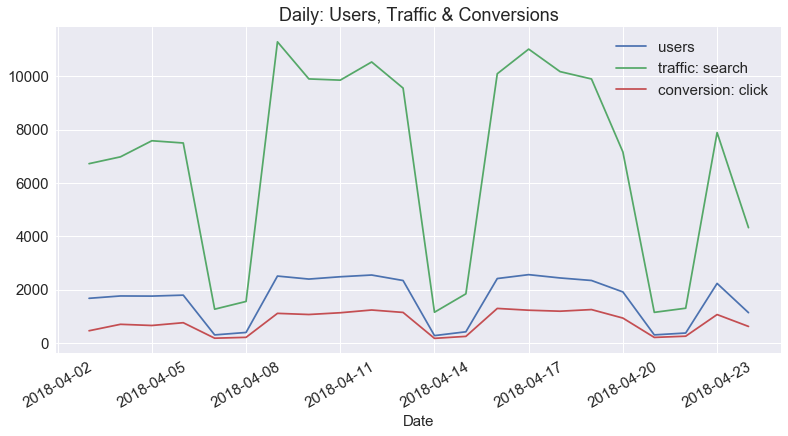

In [13]:
# Create Dataframes which aggregate the data by day
daily_users = pd.DataFrame(d2.groupby(date_label)[user_label].nunique()).reset_index()
daily_traffic = pd.DataFrame(d2.groupby(date_label)[traffic_label].sum()).reset_index()
daily_conversions = pd.DataFrame(d2.groupby(date_label)[conversion_label].sum()).reset_index()


# Plot Figures
plt.subplots(figsize=(13, 6))
plt.plot(pd.to_datetime(daily_users[date_label]), daily_users[user_label], label = 'users')
plt.plot(pd.to_datetime(daily_traffic[date_label]), daily_traffic[traffic_label], label = ('traffic: ' + traffic_label))
plt.plot(pd.to_datetime(daily_conversions[date_label]), daily_conversions[conversion_label], label = ('conversion: ' + conversion_label))

# Chart Labels and Font Size
plt.xlabel('Date', fontsize=15)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.title('Daily: Users, Traffic & Conversions', fontsize=18)
plt.legend(fontsize=15)
plt.show()

#### Overall Conversion Rate

In [14]:
round((daily_conversions[conversion_label]/daily_traffic[traffic_label]).mean()*100,2)

12.36

#### Average Overall Traffic per User

In [15]:
round((daily_traffic[traffic_label]/daily_users[user_label]).mean(),2)

4.07

#### Average Overall Conversions per User

In [16]:
round((daily_conversions[conversion_label]/daily_users[user_label]).mean(),2)

0.5

### Daily Segment Volatility Chart

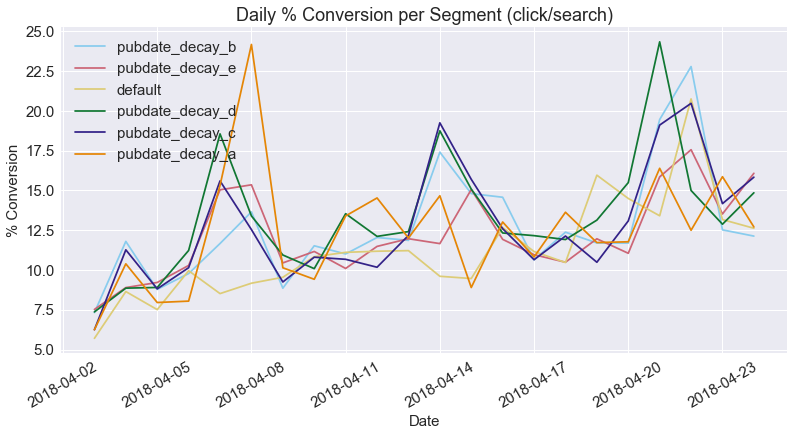

In [17]:
# Group data by day
daily_segment_traffic = pd.DataFrame(d2.groupby([date_label, segment_label])[traffic_label].sum()).reset_index()
daily_segment_conversions = pd.DataFrame(d2.groupby([date_label, segment_label])[conversion_label].sum()).reset_index()

daily_segment_conv_rate = pd.merge(daily_segment_traffic, daily_segment_conversions, on = [date_label, segment_label], how = 'left')
daily_segment_conv_rate['conversion_rate'] = 100*daily_segment_conv_rate[conversion_label]/daily_segment_conv_rate[traffic_label] 


# Plot Figures
plt.subplots(figsize=(13, 6))

for i in range(0, variations):
    df = daily_segment_conv_rate[daily_segment_conv_rate[segment_label] == segment_list[i] ]
    plt.plot(pd.to_datetime(df[date_label]), df['conversion_rate'], label = segment_list[i], color= color_hex_list[i])

# Chart Labels and Font Size
plt.xlabel('Date', fontsize=15)
plt.ylabel('% Conversion', fontsize=15)

plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
chart_title = 'Daily % Conversion per Segment ({}/{})'.format(conversion_label, traffic_label)
plt.title(chart_title, fontsize=18)
plt.legend(fontsize=15)
plt.show()

### Create Simplified Table

In [19]:
# Create a loop to aggregate the traffic and conversion for each segment.

# Specify the 'traffic' column and the 'conversion' column 
aggregation_column = [traffic_label, conversion_label]

# Create empty lists to populate in the loop below
traffic = []
conversions = [] 

# This table will the underlying table used in the subsequent sections to analyze the test results.
for i in range(variations):
    v, c = d2[d2[segment_label] == segment_list[i] ][aggregation_column[:2]].sum()

    traffic.append(v)
    conversions.append(c)
    
    
# Create a Simple Data Frame for Proportions (from the above lists)   
dfp_simple = pd.DataFrame({
    "converted": conversions,
    "traffic": traffic
}, index = segment_list)

dfp_simple

,converted,traffic
pubdate_decay_b,3175.0,27650.0
pubdate_decay_e,3074.0,27252.0
default,3049.0,27578.0
pubdate_decay_d,3186.0,26598.0
pubdate_decay_c,3026.0,26601.0
pubdate_decay_a,1534.0,13137.0


### Additional Columns

In [20]:
dfp = dfp_simple.copy().sort_index()

# Sum up all the columns
dfp.loc['Total'] = dfp.sum()

# What were the non conversions?
dfp['not_converted'] = dfp['traffic'] - dfp['converted']

# What were the different segement conversions (as well as overall)?
proportion = dfp.converted/dfp.traffic
dfp['converted_proportion'] = proportion

# Standard Error
dfp['standard_error'] = ((proportion * (1-proportion))/dfp.traffic)**(.5)

# Calculate the traffic percentage in each variation
n = dfp.loc['Total']['traffic']
dfp['population_percentage'] = dfp['traffic']/n

dfp

,converted,traffic,not_converted,converted_proportion,standard_error,population_percentage
default,3049.0,27578.0,24529.0,0.110559,0.001888,0.185316
pubdate_decay_a,1534.0,13137.0,11603.0,0.116769,0.002802,0.088277
pubdate_decay_b,3175.0,27650.0,24475.0,0.114828,0.001917,0.185800
pubdate_decay_c,3026.0,26601.0,23575.0,0.113755,0.001947,0.178751
pubdate_decay_d,3186.0,26598.0,23412.0,0.119783,0.001991,0.178731
pubdate_decay_e,3074.0,27252.0,24178.0,0.112799,0.001916,0.183125
Total,17044.0,148816.0,131772.0,0.114531,0.000826,1.000000


### Plot the Conversion Rates

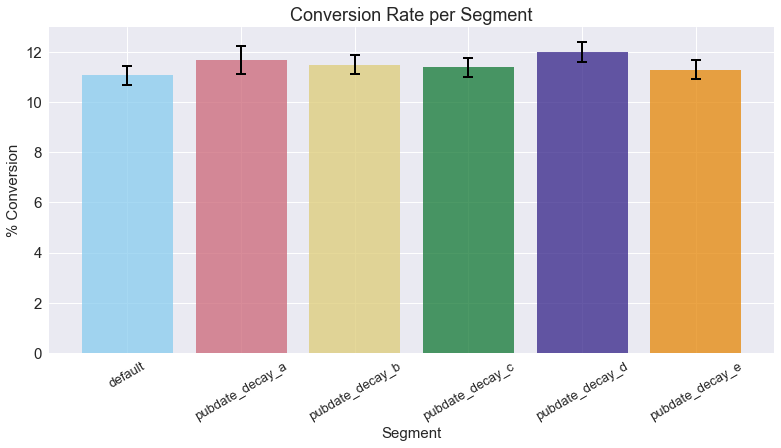

In [22]:
# Bar Plot Inputs
labels = dfp.index[:-1].tolist()
label_index = np.arange(len(labels))
values = (round(dfp['converted_proportion'][:-1]*100,2)).tolist()
half_ci = (round(dfp['standard_error'][:-1]*1.96*100,2)).tolist()

# Plot the Conversion Rate of each segment and the sample standard error
plt.subplots(figsize=(13, 6))
plt.bar(label_index, values, yerr=half_ci, alpha=0.75,
       color= color_hex_list[0:len(labels)],
       error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))
plt.xlabel('Segment', fontsize=15)
plt.ylabel('% Conversion', fontsize=15)
plt.xticks(label_index, labels, fontsize=13, rotation=30)
plt.yticks(fontsize=15)
plt.title('Conversion Rate per Segment', fontsize=18)
plt.show()

**IMPORTANT:** Please do not make any conclusions from the above graph alone. The formulas below call out segments that are statistically significant.

---

# TEST EVALUATION

## 2 Sample Proportion
*Type of test: z-test*

If you would prefer to use an online calculator (only for 2 samples), I would recommend this [one](https://abtestguide.com/calc/).

##### ~ Set up Variables ~

In [23]:
# Set up Variables (choose which two segments you'd like to compare)
variation1 = 'default'
variation2 = 'pubdate_decay_a'

### Summary of Input Variables

In [24]:
# Variable inputs
x1 = dfp.loc[variation1]['converted']
n1 = dfp.loc[variation1]['traffic']
x2 = dfp.loc[variation2]['converted']
n2 = dfp.loc[variation2]['traffic']

print(variation1, 'Converted:', x1)
print(variation1, 'Traffic:', n1)
print(variation2, 'Converted:', x2)
print(variation2, 'Traffic:', n2)

default Converted: 3049.0
default Traffic: 27578.0
pubdate_decay_a Converted: 1534.0
pubdate_decay_a Traffic: 13137.0


### Evaluate Results

In [25]:
p1 = x1/n1
p2 = x2/n2
p = (x1+x2)/(n1+n2)
print('Proportion (', variation1 ,'): {0:.2f}%'.format(100*p1))
print('Proportion (', variation2 ,'): {0:.2f}%'.format(100*p2))
print('Pooled Sample Proportion: {0:.2f}%'.format(100*p))
print('Absolute Percent Difference Between Samples: {0:.2f}%'.format(100*(p2-p1)))
print('Relative Percent Difference Between Samples: {0:.2f}%'.format(100*(p2-p1)/p1))


var = p*(1-p)*(1/n1+1/n2)
se = math.sqrt(var)
print('\nVariance: {0:.4f}%'.format(100*var))
print('Standard Error: {0:.2f}%'.format(100*se))

z = (p1-p2)/se
pvalue = 1-stats.norm.cdf(abs(z))
pvalue *= 2-one_sided
print('\nz-stat: {z}'.format(z=z))
print('p-value: {p}'.format(p=pvalue))

Proportion ( default ): 11.06%
Proportion ( pubdate_decay_a ): 11.68%
Pooled Sample Proportion: 11.26%
Absolute Percent Difference Between Samples: 0.62%
Relative Percent Difference Between Samples: 5.62%

Variance: 0.0011%
Standard Error: 0.34%

z-stat: -1.853521168423394
p-value: 0.03190384745834518


### Detectable Difference
Does it meet our test set up metrics? Given our sample size (take the lowest of the two examples), are we able to actually detect the above `Absolute Percent Difference Between Samples`?

In [26]:
min_detectable_effect_size = measurable_effect_size(min([n1, n2]), alpha_Zscore, beta_Zscore, p1)
min_detectable_effect_size

0.009620703648732187

**Need more data?**

Do we need to collect more data for these two samples?

In [27]:
abs(p2-p1) >= min_detectable_effect_size

if abs(p2-p1) >= min_detectable_effect_size:
   print("No, we do not need to collect more data to verify whether this difference is truly statistically significant.")
else:
   print("Yes, we need to collect more data to make a claim of signficance about the above difference. \n\nSTOP")

Yes, we need to collect more data to make a claim of signficance about the above difference. 

STOP


#### Result Interpretation
Before going to this step, make sure we do not need to collect more data.

In [28]:
print('Is the p-value {p} less than the cutoff, alpha, {alpha}?\n'.format(p=round(pvalue,5), alpha=alpha))
if (pvalue < alpha):
    print('The p-value is smaller than the cutoff, therefore we reject the null-hypothesis (null-hypothesis = no difference).')
else: 
    print('Fail to reject the null-hypothesis.')

Is the p-value 0.0319 less than the cutoff, alpha, 0.05?

The p-value is smaller than the cutoff, therefore we reject the null-hypothesis (null-hypothesis = no difference).


### Confidence Interval - for Effect Size

In [29]:
# Calculate the z-stat for selected one or two tailed test
z_critical = stats.norm.ppf(1-alpha*(1-0.5*(1-one_sided)))

# Calculate the lower and upper confidence intervals for the difference between the samples
ci_low = (p2-p1) - z_critical*se
ci_upp = (p2-p1) + z_critical*se

print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( 0.07% , 1.17% )


### Stats Model Formula

The below is the same as the result above, but for a two-tailed test.

In [30]:
counts = np.array([x1, x2])
nobs = np.array([n1, n2])

# Options for alternative parameter  [‘two-sided’, ‘smaller’, ‘larger’]
stat, pval = proportions_ztest(counts, nobs, alternative = 'smaller')
print('z-stat: {0:.4f}'.format(stat))
print('p-value: {0:.8f}'.format(pval))

z-stat: -1.8535
p-value: 0.03190385


#### Extra

In [31]:
# 2 Tailed Result
pvalue = 1-stats.norm.cdf(abs(z))
pvalue *= 2-False
print('p-value: {p}'.format(p=pvalue))

p-value: 0.06380769491669036


In [32]:
# 1 Tailed Result
pvalue = 1-stats.norm.cdf(abs(z))
pvalue *= 2-True
print('p-value: {p}'.format(p=pvalue))

p-value: 0.03190384745834518


## 2+ Sample Proportion
*Type of test: Chi Square*

**Guiding Questions**
- Do we expect the observed frequencies to perfectly match the expected frequencies if the null hypothesis is true?
- How likely is it to find a discrepancy this extreme or more if our null hypothesis is true?

**Hypotheses**
- H0: There is no association between segment and conversion
- HA: There is an association between segment and conversion
    - But we don’t know (for sure) which request types have different proportions from each other → inference or estimation on pairwise proportion differences (see Marascuilo Procedure below to answer this question). 

### Main Question: 
Is there a difference between any of the versions?

### Observed Proportions

In [33]:
# DataFrame Proportion Transposed Observed = dfpTo
dfpTo = dfp[['converted', 'not_converted', 'traffic']].T
dfpTo

,default,pubdate_decay_a,pubdate_decay_b,pubdate_decay_c,pubdate_decay_d,pubdate_decay_e,Total
converted,3049.0,1534.0,3175.0,3026.0,3186.0,3074.0,17044.0
not_converted,24529.0,11603.0,24475.0,23575.0,23412.0,24178.0,131772.0
traffic,27578.0,13137.0,27650.0,26601.0,26598.0,27252.0,148816.0


### Expected Proportions

In [34]:
# DataFrame Proportion Transposed Expected = dfpTe
dfpTe = dfpTo.copy()

# Replace with expected values
for i in range(variations):
    for j in range(0, 2):
        dfpTe.iloc[j,i] = (dfpTo.loc['traffic'][i]*dfpTo['Total'][j])/n

dfpTe

,default,pubdate_decay_a,pubdate_decay_b,pubdate_decay_c,pubdate_decay_d,pubdate_decay_e,Total
converted,3158.527524,1504.589748,3166.773734,3046.631034,3046.287442,3121.190517,17044.0
not_converted,24419.472476,11632.410252,24483.226266,23554.368966,23551.712558,24130.809483,131772.0
traffic,27578.000000,13137.000000,27650.000000,26601.000000,26598.000000,27252.000000,148816.0


### Calculate Chi Square and p-value

In [35]:
# Drop the last column AND drop the last row (the columns with the totals)
o = dfpTo.drop(dfpTo.columns[-1], axis = 1)[:-1]
e = dfpTe.drop(dfpTe.columns[-1], axis = 1)[:-1]

ss = (o-e)**2/e
ch2 = ss.values.sum()
ch2

13.162716085013036

In [37]:
# P-value for a chi score with variations-1 degrees of freedom
pvalue_chi = 1 - stats.chi2.cdf(ch2, variations-1)
pvalue_chi

0.021900733249048843

#### Result Interpretation

In [38]:
print('Is the p-value {p} less than the cutoff, alpha, {alpha}?\n'.format(p=round(pvalue_chi,5), alpha=alpha))
if (pvalue < alpha):
    print('The p-value is smaller than the cutoff, therefore we reject the null-hypothesis (null-hypothesis = no difference).')
else: 
    print('Fail to reject the null-hypothesis.')

Is the p-value 0.0219 less than the cutoff, alpha, 0.05?

The p-value is smaller than the cutoff, therefore we reject the null-hypothesis (null-hypothesis = no difference).


#### Stats Model Formula

In [39]:
# stat, pval, margins = proportions_chisquare(counts, nobs)
proportions_chisquare(dfp_simple.converted, dfp_simple.traffic) 

(13.162716085013036, 0.021900733249048846, (array([[ 3175., 24475.],
         [ 3074., 24178.],
         [ 3049., 24529.],
         [ 3186., 23412.],
         [ 3026., 23575.],
         [ 1534., 11603.]]), array([[ 3166.77373401, 24483.22626599],
         [ 3121.19051715, 24130.80948285],
         [ 3158.52752392, 24419.47247608],
         [ 3046.28744221, 23551.71255779],
         [ 3046.6310343 , 23554.3689657 ],
         [ 1504.58974841, 11632.41025159]])))

---

### Main Question: 
Which versions performed better than the others, if any?

### Marascuilo Procedure (Similar to Tukey-Kramer Test)
Calculate which proportions are statistically different. (Reference: https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm)

Iterate through all the possible pairwise tests.

In [40]:
# Create lists to iterate through
prp = list(dfp_simple['converted']/dfp_simple['traffic'])
vis = list(dfp_simple['traffic'])
seg = list(dfp_simple.index.values)

# Calculate the chi square stat
c2 = stats.chi2.cdf(ch2, variations-1)

# Empty lists (to be populated in the for loop)
diff = []
critical_value = []
segment1 = []
segment2 = []
proportion1 = []
proportion2 = []
segment1_size = []
segment2_size = []
smallest_measurable_effect_size = []

In [41]:
# Pairwise comparisons (iterate through all combinations)
for i in range(0,(variations)):
    for j in range((i+1),variations):
        segment1.append(seg[i])
        segment2.append(seg[j])
        
        proportion1.append(prp[i])
        proportion2.append(prp[j])
        
        segment1_size.append(vis[i])
        segment2_size.append(vis[j])
        smaller_sample_size = min(vis[i], vis[j])
        # Use the maximum of the two proportions, more conservative, to calculate minimal detectable effect size in the next step
        max_proportion = max(prp[i], prp[j])
        es = measurable_effect_size(smaller_sample_size, alpha_Zscore, beta_Zscore, max_proportion)
        smallest_measurable_effect_size.append(es)

        d = prp[i]-prp[j]
        diff.append(d)
    
        cr = math.sqrt(c2)*math.sqrt(prp[i]*(1-prp[i])/vis[i] + prp[j]*(1-prp[j])/vis[j])
        critical_value.append(cr)

# Verify that every list is the same length
print(len(segment1))
print(len(segment2)) 
print(len(diff))
print(len(critical_value))

15
15
15
15


In [43]:
# Create a new dataframe for the Marascuilo Procedure Calculations
dfm = []
dfm = pd.DataFrame({
    "segment1" : segment1,
    "segment2" : segment2,
    "segment1_size": segment1_size,
    "segment2_size": segment2_size,
    "proportion1": proportion1,
    "proportion2": proportion2,
    "smallest_measurable_effect_size": smallest_measurable_effect_size,
    "diff": diff,
    "critical_value": critical_value
})

### Determine significance at the alpha level
Based on our test setup and population per segment, are we able to make a claim on the statistical significance of our results?

Test Setup
- reliability - alpha 
- power - beta 
- sample size
- effect size

In [45]:
# Pre-final step, but NOT the final outcome
dfm['significant'] = (abs(dfm['diff']) > dfm['critical_value'])

# The final verdict!
dfm['signficant_effect_size'] = ( (abs(dfm['diff']) > dfm['critical_value']) & ( dfm['diff'] >= 
                                 dfm['smallest_measurable_effect_size']) )
    
# Organize the columns 
column_order = ['segment1', 'proportion1', 'segment2', 'proportion2', 'diff', 'smallest_measurable_effect_size',
                'critical_value', 'significant', 'signficant_effect_size']

# Sort by the biggest, statistically significant improvement
dfm[column_order].sort_values(['diff', 'signficant_effect_size'], ascending = [False, True])

,segment1,proportion1,segment2,proportion2,diff,smallest_measurable_effect_size,critical_value,significant,signficant_effect_size
12,pubdate_decay_d,0.119783,pubdate_decay_c,0.113755,0.006028,0.007001,0.002754,True,False
1,pubdate_decay_b,0.114828,default,0.110559,0.004269,0.006751,0.002661,True,False
13,pubdate_decay_d,0.119783,pubdate_decay_a,0.116769,0.003014,0.009962,0.003399,False,False
5,pubdate_decay_e,0.112799,default,0.110559,0.002240,0.006739,0.002661,False,False
0,pubdate_decay_b,0.114828,pubdate_decay_e,0.112799,0.002029,0.006791,0.002681,False,False
3,pubdate_decay_b,0.114828,pubdate_decay_c,0.113755,0.001073,0.006874,0.002702,False,False
7,pubdate_decay_e,0.112799,pubdate_decay_c,0.113755,-0.000956,0.006846,0.002702,False,False
4,pubdate_decay_b,0.114828,pubdate_decay_a,0.116769,-0.001941,0.009853,0.003358,False,False
14,pubdate_decay_c,0.113755,pubdate_decay_a,0.116769,-0.003014,0.009853,0.003374,False,False
10,default,0.110559,pubdate_decay_c,0.113755,-0.003196,0.006846,0.002682,True,False


**Final Result:** Only the samples that have a `significant_effect_size` == `True` are ones that we can confidently say we saw a statistically significant difference at the initial alpha and beta levels established.

### Which segment pairs had a statistically significant difference?

In [49]:
dfm[dfm['signficant_effect_size'] == True][['segment1', 'segment2']]

,segment1,segment2


---

**STYLE: Add color to all headers**

In [31]:
%%html
<style>
h1   {color: green;}
h2   {color: blue;}
h5   {color: red;}           
</style>